<center><h1>Sound Classification <br><small>Example</small></h1></center>
<br><br>

<center style="font-size:140%;">
    <strong>Toni Heittola</strong><br>
    <small>toni.heittola@tuni.fi</small>
</center>
<table><tr>
<td><img src="images/ARG_logo.png" alt="Drawing" style="width:350px;"/></td>
    <td><img src="images/marvel_logo.png" alt="Drawing" style="width:350px;"/></td>
<td><img src="images/TAU_logo.png" alt="Drawing" style="width:250px;"/></td>
</tr></table>

# Introduction

This presentation goes through basic steps to build a **CNN**-based sound classifier. 


## Outline

- Dataset
- Cross-validation set
- Acoustic features
- Learning the acoustic model
- Testing the learned model
- Evaluation

## Application &ndash; Acoustic scene classification

*The goal of acoustic scene classification is to classify a test recording into one of the predefined ten acoustic scene classes*

<img src="images/asc.png" width="400">

## Key tools used in this example:

- **`dcase_util`** &ndash; used to ease data handling, https://github.com/DCASE-REPO/dcase_util
- **`keras`** &ndash; neural network API for fast experimentation used on top of **`tensorflow`** machine learning framework
- **`scikit-learn`** &ndash; set of machine learning tools, here used to evaluate the system output

In [1]:
import dcase_util
from dcase_util.containers import AudioContainer
from dcase_util.features import MelExtractor
from dcase_util.data import ProbabilityEncoder
import os, numpy
import matplotlib.pyplot as plt
import sklearn
import time
%matplotlib inline

# Handy tool to print data in HTML form
log = dcase_util.ui.FancyHTMLPrinter()

# Paths to store data
data_storage_path = 'data'
dataset_storage_path = os.path.join(data_storage_path, 'datasets')
feature_storage_path = os.path.join(data_storage_path, 'features_asc')
dcase_util.utils.Path().create(
    [data_storage_path, dataset_storage_path, feature_storage_path]
)


# Filename for acoustic model
model_filename = os.path.join(data_storage_path, 'model_asc.h5')  

def get_feature_filename(audio_filename, feature_storage_path):
    """Get feature filename from audio filename. """
    
    return dcase_util.utils.Path(path=audio_filename).modify(
        path_base=feature_storage_path, 
        filename_extension='.npy'
    )
    
def get_feature_matrix(audio_filename, feature_storage_path=os.path.join('data', 'features_asc')):    
    """Extract acoustic features (log mel-energies) for given audio file and store them."""
    
    feature_filename = get_feature_filename(audio_filename, feature_storage_path)
    if os.path.exists(feature_filename):
        return numpy.load(feature_filename)
    else:
        audio = dcase_util.containers.AudioContainer().load(filename=audio_filename,mono=True)
        mel_extractor = dcase_util.features.MelExtractor(n_mels=40, win_length_seconds=0.04, hop_length_seconds=0.02, fs=audio.fs)
        mel_data = mel_extractor.extract(y=audio)
        numpy.save(feature_filename, mel_data)
        return mel_data
    
# Setup Keras to use tensorflow as backend
dcase_util.tfkeras.setup_keras(backend='tensorflow', device='cuda')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *

from tensorflow.keras.models import Model

from codecarbon import EmissionsTracker, OfflineEmissionsTracker
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.ERROR)

# Dataset

**`dcase_util`** implements dataset handling classes that can be used to access datasets through uniform API:

- Download the dataset from the origin, e.g. zenodo.org
- Extract downloaded Zip-packages and check data integrity 
- Access metadata (e.g. filter data based on scene labels)
- Access cross-validation sets bundled with the dataset

**TUT Urban Acoustic Scenes 2018** development dataset is used in this example:
- The dataset was used as a development dataset in [acoustic scene classfication task](https://dcase.community/challenge2018/task-acoustic-scene-classification#subtask-a) (task1A) in the DCASE2018 Challenge
- Recordings from 10 scene classes, 6 large European cities
- 5-6 minute recordings around selected locations, which were split into **10 second audio segments**
- 8640 segments in total


Dataset can be downloaded and accessed easily by using **dataset handler class** from `dcase_util`:

In [2]:
db = dcase_util.datasets.TUTUrbanAcousticScenes_2018_DevelopmentSet(
    data_path=dataset_storage_path
).initialize()

In [3]:
print('Audio file count :', len(db.audio_files))
print('Scene class count:', len(db.scene_labels()))

Audio file count : 8640
Scene class count: 10


In [4]:
print('Scene labels:', db.scene_labels())

Scene labels: ['airport', 'bus', 'metro', 'metro_station', 'park', 'public_square', 'shopping_mall', 'street_pedestrian', 'street_traffic', 'tram']


Basic statistics of the dataset:

In [5]:
db.meta.show(mode='print')

MetaDataContainer :: Class
Items                               : 8640 
Unique
  Files                             : 8640 
  Scene labels                      : 10 
  Event labels                      : 0 
  Tags                              : 0 
  Identifiers                       : 286 
  Datasets                          : 0 
  Source labels                     : 1 

Scene statistics
  Scene label             Count   Identifiers   
  --------------------   ------   -----------   
  airport                   864            22   
  bus                       864            36   
  metro                     864            29   
  metro_station             864            40   
  park                      864            25   
  public_square             864            24   
  shopping_mall             864            22   
  street_pedestrian         864            28   
  street_traffic            864            25   
  tram                      864            35   




Identifiers are unique recording locations:

In [6]:
# Identifiers for items with bus scene label
db.meta.filter(scene_label='street_traffic').unique_identifiers[0:6]

['barcelona-161',
 'barcelona-162',
 'barcelona-163',
 'barcelona-268',
 'helsinki-164',
 'helsinki-165']

## Important aspects

- We need to be aware of the **recording location** of each segment
- Audio segments from the same location around the same time are **highly correlated**
- Unrealistic to be able to train the system and test it with material recorded **in the same location only a few minutes apart**
- The cross-validation set should take this into account to give **realistic performance estimates**

# Cross-validation set

- Dataset is released with a single **train/test**-split
- We need also a **validation set** to follow system performance on **unseen data** during the training process
- Dataset class from `dcase_util` can be used to split the original training set into a new training set and validation set (70/30 split done according to recording locations)

## Train/Test split bundled with the dataset

In [7]:
train_items = db.train(1).stats()['scenes']['count']
train_items = numpy.append(train_items, numpy.sum(train_items))
train_ids = db.train(1).stats()['scenes']['identifiers']
train_ids = numpy.append(train_ids, numpy.sum(train_ids))

test_items = db.eval(1).stats()['scenes']['count']
test_items = numpy.append(test_items, numpy.sum(test_items))
test_ids = db.eval(1).stats()['scenes']['identifiers']
test_ids = numpy.append(test_ids, numpy.sum(test_ids))
labels = db.scene_labels() 
labels.append('Overall')

log.table(
    cell_data=[
        labels, 
        train_items,         
        test_items,        
        train_items / (train_items + test_items) * 100.0,
        train_ids, 
        test_ids, 
        #train_ids / ( train_ids + test_ids)* 100.0,
    ],
    column_headers=['Scene label', 'Train set (items)', 'Test set (items)', 'Split percentage', 'Train (locations)', 'Test (locations)'],
    column_types=['str18', 'int', 'int', 'int', 'int', 'int', 'int'],
    column_separators=[0,3],
    row_separators=[10],
    scaling=100
)

Scene label,Train set (items),Test set (items),Split percentage,Train (locations),Test (locations)
airport,599,265,69,15,7
bus,622,242,71,26,10
metro,603,261,69,20,9
metro_station,605,259,70,28,12
park,622,242,71,18,7
public_square,648,216,75,18,6
shopping_mall,585,279,67,16,6
street_pedestrian,617,247,71,20,8
street_traffic,618,246,71,18,7
tram,603,261,69,24,11


## Generating validation set

- During the training, we need a **validation set** to follow system performance on **unseen data**
- The validation set can be extracted from the training set while taking location identifiers into account
- Dataset class can be used to generate a validation set and a new training set:

In [8]:
training_files, validation_files = db.validation_split(
    validation_amount=0.3, # split target 30% 
    fold=1, # cross-validation fold id      
    # balance based on scenes and locations
    balancing_mode='identifier_two_level_hierarchy', 
    disable_progress_bar=True
)

train_meta = db.train(1).filter(file_list=training_files)
validation_meta = db.train(1).filter(file_list=validation_files)

In [9]:
print('Training items  :', len(training_files))
print('Validation items:', len(validation_files))

Training items  : 4134
Validation items: 1988


## Train / Validation statistics

In [10]:
train_items = train_meta.stats()['scenes']['count']
train_items = numpy.append(train_items, numpy.sum(train_items))
train_ids = train_meta.stats()['scenes']['identifiers']
train_ids = numpy.append(train_ids, numpy.sum(train_ids))

validation_items = validation_meta.stats()['scenes']['count']
validation_items = numpy.append(validation_items, numpy.sum(validation_items))
validation_ids = validation_meta.stats()['scenes']['identifiers']
validation_ids = numpy.append(validation_ids, numpy.sum(validation_ids))

test_items = db.eval(1).stats()['scenes']['count']
test_items = numpy.append(test_items, numpy.sum(test_items))
test_ids = db.eval(1).stats()['scenes']['identifiers']
test_ids = numpy.append(test_ids, numpy.sum(test_ids))
labels = db.scene_labels() 
labels.append('Overall')

log.table(
    cell_data=[
        labels, 
        train_ids, 
        validation_ids, 
        validation_ids / ( train_ids + validation_ids)* 100.0,
        #test_ids,         

        train_items,         
        validation_items,  
        validation_items / (train_items + validation_items) * 100.0,
        #test_items,        

    ],
    column_headers=['Scene label', 
                    'Train (locations)', 'Validation (locations)', 'Split percentage', 
                    #'Test (locations)',
                    'Train set (items)', 'Validation set (items)', 'Split percentage', 
                    #'Test set (items)',
                   
                   ],
    column_types=['str17', 'int', 'int', 'float1', 'int', 'int', 'float1', 'int'],
    column_separators=[0,3],
    row_separators=[10],
    scaling=110
)

Scene label,Train (locations),Validation (locations),Split percentage,Train set (items),Validation set (items),Split percentage
airport,9,6,40.0,411,188,31.4
bus,16,10,38.5,413,209,33.6
metro,13,7,35.0,422,181,30.0
metro_station,18,10,35.7,408,197,32.6
park,12,6,33.3,425,197,31.7
public_square,12,6,33.3,433,215,33.2
shopping_mall,10,6,37.5,360,225,38.5
street_pedestrian,13,7,35.0,422,195,31.6
street_traffic,12,6,33.3,425,193,31.2
tram,16,8,33.3,415,188,31.2


# Features &ndash; log-mel energies

Feature extractor initialized with parameters and used to extract features:

In [11]:
# Load audio 
audio = dcase_util.containers.AudioContainer().load(
    filename=db.audio_files[0], mono=True
)

# Create feature extractor
mel_extractor = dcase_util.features.MelExtractor(
    n_mels=40, 
    win_length_seconds=0.04, 
    hop_length_seconds=0.02, 
    fs=audio.fs
)

# Extract features
mel_data = mel_extractor.extract(y=audio)

## Feature matrix

In [12]:
print('mel_data shape', '(frequency, time):\n', mel_data.shape)

mel_data shape (frequency, time):
 (40, 501)


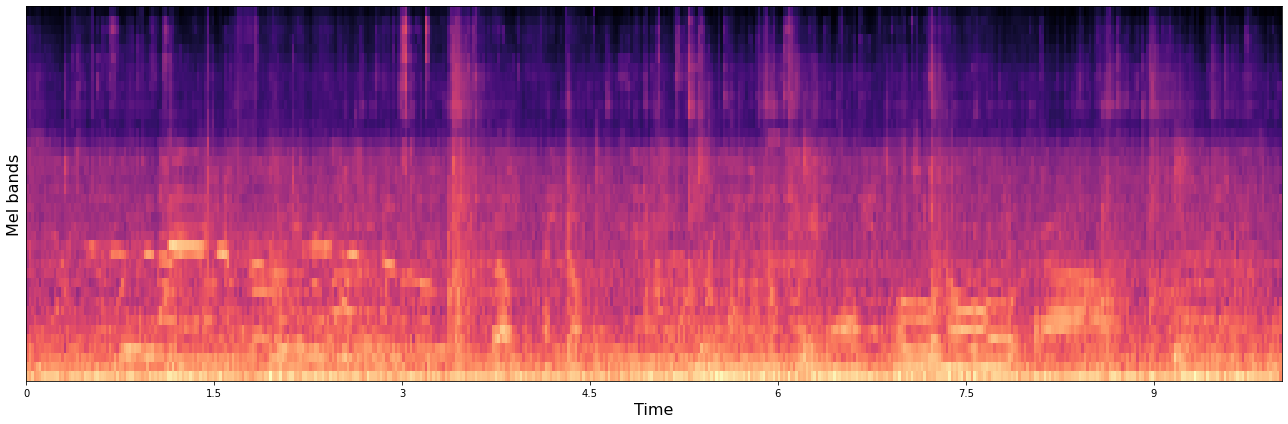

In [13]:
dcase_util.containers.FeatureContainer(
    data=mel_data,
    time_resolution=mel_extractor.hop_length_seconds
).plot(
    ylabel='Mel bands',
    xlabel='Time',
    figsize=(18,6)
)

# Learning examples

1) **Feature matrix**

In [14]:
# Load audio
audio = dcase_util.containers.AudioContainer().load(
    filename=train_meta[0].filename, mono=True
)

# Extract log-mel energies
sequence_length = 500        # 10s / 0.02s = 500
mel_extractor = dcase_util.features.MelExtractor(
    n_mels=40, win_length_seconds=0.04, hop_length_seconds=0.02, fs=audio.fs
)

features = mel_extractor.extract(audio.data)[:,:sequence_length]

In [15]:
print('features shape', '(frequency, time):\n', features.shape)

features shape (frequency, time):
 (40, 500)


2) **Target vector** (one-hot encoded vector)

In [16]:
# List of scene labels
scene_labels = db.scene_labels()               

# Empty target vector
target_vector = numpy.zeros(len(scene_labels))      

# Place one at correct position 
target_vector[scene_labels.index(train_meta[0].scene_label)] = 1

In [17]:
target_vector

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
print('target vector shape', '(classes, ):\n', target_vector.shape)

target vector shape (classes, ):
 (10,)


# Collect training data

In [19]:
X_train = []
Y_train = []
for item in train_meta:
    print('Load', db.absolute_to_relative_path(item.filename))
    
    # Extract features, load them from file if they exists, if not extract and save
    features = get_feature_matrix(item.filename, feature_storage_path)[:,:sequence_length]
    
    # Extract features, store only in memory
    #features = mel_extractor.extract(
    #    dcase_util.containers.AudioContainer().load(filename=item.filename,mono=True)
    #)

    # Targets
    target_vector = numpy.zeros(len(scene_labels))
    target_vector[scene_labels.index(item.scene_label)] = 1
    
    X_train.append(features) 
    Y_train.append(target_vector)
    
X_train = numpy.moveaxis(numpy.dstack(X_train), 2, 0)
Y_train = numpy.vstack(Y_train)
print('X_train shape', X_train.shape)
print('Y_train shape', Y_train.shape)

Load audio/airport-barcelona-1-16-a.wav
Load audio/airport-barcelona-1-17-a.wav
Load audio/airport-barcelona-1-18-a.wav
Load audio/airport-barcelona-1-19-a.wav
Load audio/airport-barcelona-1-20-a.wav
Load audio/airport-barcelona-1-21-a.wav
Load audio/airport-barcelona-1-22-a.wav
Load audio/airport-barcelona-1-23-a.wav
Load audio/airport-barcelona-1-24-a.wav
Load audio/airport-barcelona-1-25-a.wav
Load audio/airport-barcelona-1-26-a.wav
Load audio/airport-barcelona-1-27-a.wav
Load audio/airport-barcelona-1-28-a.wav
Load audio/airport-barcelona-1-29-a.wav
Load audio/airport-barcelona-1-30-a.wav
Load audio/airport-barcelona-1-31-a.wav
Load audio/airport-barcelona-1-32-a.wav
Load audio/airport-barcelona-1-33-a.wav
Load audio/airport-barcelona-1-34-a.wav
Load audio/airport-barcelona-1-35-a.wav
Load audio/airport-barcelona-1-36-a.wav
Load audio/airport-barcelona-1-37-a.wav
Load audio/airport-barcelona-1-38-a.wav
Load audio/airport-barcelona-1-39-a.wav
Load audio/airport-barcelona-1-40-a.wav


Load audio/airport-paris-7-351-a.wav
Load audio/airport-paris-7-352-a.wav
Load audio/airport-paris-9-371-a.wav
Load audio/airport-paris-9-372-a.wav
Load audio/airport-paris-9-373-a.wav
Load audio/airport-paris-9-374-a.wav
Load audio/airport-paris-9-375-a.wav
Load audio/airport-paris-9-376-a.wav
Load audio/airport-paris-9-377-a.wav
Load audio/airport-paris-9-378-a.wav
Load audio/airport-paris-9-379-a.wav
Load audio/airport-paris-9-380-a.wav
Load audio/airport-paris-9-381-a.wav
Load audio/airport-paris-9-382-a.wav
Load audio/airport-paris-9-383-a.wav
Load audio/airport-paris-9-384-a.wav
Load audio/airport-paris-9-385-a.wav
Load audio/airport-paris-9-386-a.wav
Load audio/airport-paris-9-387-a.wav
Load audio/airport-paris-9-388-a.wav
Load audio/airport-paris-9-389-a.wav
Load audio/airport-paris-9-390-a.wav
Load audio/airport-paris-9-391-a.wav
Load audio/airport-paris-9-392-a.wav
Load audio/airport-paris-9-393-a.wav
Load audio/airport-paris-9-394-a.wav
Load audio/airport-paris-9-395-a.wav
L

Load audio/bus-helsinki-19-759-a.wav
Load audio/bus-helsinki-19-760-a.wav
Load audio/bus-helsinki-19-761-a.wav
Load audio/bus-helsinki-19-762-a.wav
Load audio/bus-helsinki-19-763-a.wav
Load audio/bus-helsinki-19-764-a.wav
Load audio/bus-helsinki-19-765-a.wav
Load audio/bus-helsinki-19-766-a.wav
Load audio/bus-helsinki-19-767-a.wav
Load audio/bus-helsinki-19-768-a.wav
Load audio/bus-helsinki-19-769-a.wav
Load audio/bus-helsinki-19-770-a.wav
Load audio/bus-helsinki-19-771-a.wav
Load audio/bus-helsinki-19-772-a.wav
Load audio/bus-helsinki-19-773-a.wav
Load audio/bus-helsinki-19-774-a.wav
Load audio/bus-helsinki-19-775-a.wav
Load audio/bus-helsinki-19-776-a.wav
Load audio/bus-helsinki-19-777-a.wav
Load audio/bus-helsinki-19-778-a.wav
Load audio/bus-helsinki-19-779-a.wav
Load audio/bus-london-21-807-a.wav
Load audio/bus-london-21-808-a.wav
Load audio/bus-london-21-809-a.wav
Load audio/bus-london-21-810-a.wav
Load audio/bus-london-21-811-a.wav
Load audio/bus-london-21-812-a.wav
Load audio/bu

Load audio/metro-barcelona-42-1267-a.wav
Load audio/metro-barcelona-42-1268-a.wav
Load audio/metro-barcelona-42-1269-a.wav
Load audio/metro-barcelona-42-1270-a.wav
Load audio/metro-barcelona-42-1271-a.wav
Load audio/metro-barcelona-42-1272-a.wav
Load audio/metro-barcelona-42-1273-a.wav
Load audio/metro-barcelona-42-1274-a.wav
Load audio/metro-barcelona-42-1275-a.wav
Load audio/metro-barcelona-42-1276-a.wav
Load audio/metro-barcelona-42-1277-a.wav
Load audio/metro-barcelona-42-1278-a.wav
Load audio/metro-barcelona-42-1279-a.wav
Load audio/metro-barcelona-42-1280-a.wav
Load audio/metro-barcelona-42-1281-a.wav
Load audio/metro-barcelona-42-1282-a.wav
Load audio/metro-barcelona-42-1283-a.wav
Load audio/metro-barcelona-42-1284-a.wav
Load audio/metro-barcelona-42-1285-a.wav
Load audio/metro-barcelona-42-1286-a.wav
Load audio/metro-barcelona-42-1287-a.wav
Load audio/metro-barcelona-42-1288-a.wav
Load audio/metro-barcelona-42-1289-a.wav
Load audio/metro-barcelona-42-1290-a.wav
Load audio/metro

Load audio/metro-stockholm-56-1651-a.wav
Load audio/metro-stockholm-56-1652-a.wav
Load audio/metro-stockholm-56-1653-a.wav
Load audio/metro-stockholm-56-1654-a.wav
Load audio/metro-stockholm-56-1655-a.wav
Load audio/metro-stockholm-56-1656-a.wav
Load audio/metro-stockholm-56-1657-a.wav
Load audio/metro-stockholm-56-1658-a.wav
Load audio/metro-stockholm-56-1659-a.wav
Load audio/metro-stockholm-56-1660-a.wav
Load audio/metro-stockholm-56-1661-a.wav
Load audio/metro-stockholm-56-1662-a.wav
Load audio/metro-stockholm-56-1663-a.wav
Load audio/metro-stockholm-56-1664-a.wav
Load audio/metro-stockholm-56-1665-a.wav
Load audio/metro-stockholm-56-1666-a.wav
Load audio/metro-stockholm-56-1667-a.wav
Load audio/metro-stockholm-56-1668-a.wav
Load audio/metro-stockholm-56-1669-a.wav
Load audio/metro-stockholm-56-1670-a.wav
Load audio/metro-stockholm-56-1671-a.wav
Load audio/metro-stockholm-56-1672-a.wav
Load audio/metro-stockholm-56-1673-a.wav
Load audio/metro-stockholm-56-1674-a.wav
Load audio/metro

Load audio/metro_station-london-69-2035-a.wav
Load audio/metro_station-london-69-2036-a.wav
Load audio/metro_station-london-70-2037-a.wav
Load audio/metro_station-london-70-2038-a.wav
Load audio/metro_station-london-70-2039-a.wav
Load audio/metro_station-london-70-2040-a.wav
Load audio/metro_station-london-70-2041-a.wav
Load audio/metro_station-london-70-2042-a.wav
Load audio/metro_station-london-70-2043-a.wav
Load audio/metro_station-london-70-2044-a.wav
Load audio/metro_station-london-70-2045-a.wav
Load audio/metro_station-london-70-2046-a.wav
Load audio/metro_station-london-70-2047-a.wav
Load audio/metro_station-london-70-2048-a.wav
Load audio/metro_station-london-72-2050-a.wav
Load audio/metro_station-london-72-2051-a.wav
Load audio/metro_station-london-72-2052-a.wav
Load audio/metro_station-london-72-2053-a.wav
Load audio/metro_station-london-72-2054-a.wav
Load audio/metro_station-london-72-2055-a.wav
Load audio/metro_station-london-72-2056-a.wav
Load audio/metro_station-london-72

Load audio/park-barcelona-89-2445-a.wav
Load audio/park-barcelona-89-2446-a.wav
Load audio/park-barcelona-89-2447-a.wav
Load audio/park-barcelona-89-2448-a.wav
Load audio/park-barcelona-89-2449-a.wav
Load audio/park-barcelona-89-2450-a.wav
Load audio/park-barcelona-89-2451-a.wav
Load audio/park-barcelona-89-2452-a.wav
Load audio/park-barcelona-89-2453-a.wav
Load audio/park-barcelona-89-2454-a.wav
Load audio/park-barcelona-89-2455-a.wav
Load audio/park-barcelona-89-2456-a.wav
Load audio/park-barcelona-89-2457-a.wav
Load audio/park-barcelona-89-2458-a.wav
Load audio/park-barcelona-89-2459-a.wav
Load audio/park-barcelona-89-2460-a.wav
Load audio/park-barcelona-89-2461-a.wav
Load audio/park-barcelona-89-2462-a.wav
Load audio/park-barcelona-89-2463-a.wav
Load audio/park-barcelona-89-2464-a.wav
Load audio/park-barcelona-91-2501-a.wav
Load audio/park-barcelona-91-2502-a.wav
Load audio/park-barcelona-91-2503-a.wav
Load audio/park-barcelona-91-2504-a.wav
Load audio/park-barcelona-91-2505-a.wav


Load audio/park-stockholm-103-2914-a.wav
Load audio/park-stockholm-103-2915-a.wav
Load audio/park-stockholm-103-2916-a.wav
Load audio/park-stockholm-103-2917-a.wav
Load audio/park-stockholm-103-2918-a.wav
Load audio/park-stockholm-103-2919-a.wav
Load audio/park-stockholm-103-2920-a.wav
Load audio/park-stockholm-103-2921-a.wav
Load audio/park-stockholm-103-2922-a.wav
Load audio/park-stockholm-103-2923-a.wav
Load audio/park-stockholm-103-2924-a.wav
Load audio/park-stockholm-103-2925-a.wav
Load audio/park-stockholm-103-2926-a.wav
Load audio/park-stockholm-103-2927-a.wav
Load audio/park-stockholm-103-2928-a.wav
Load audio/park-stockholm-103-2929-a.wav
Load audio/park-stockholm-103-2930-a.wav
Load audio/park-stockholm-103-2931-a.wav
Load audio/park-stockholm-103-2932-a.wav
Load audio/park-stockholm-103-2933-a.wav
Load audio/park-stockholm-103-2934-a.wav
Load audio/park-stockholm-103-2935-a.wav
Load audio/park-stockholm-103-2936-a.wav
Load audio/park-stockholm-103-2937-a.wav
Load audio/park-

Load audio/public_square-london-114-3330-a.wav
Load audio/public_square-london-114-3331-a.wav
Load audio/public_square-london-114-3332-a.wav
Load audio/public_square-london-114-3333-a.wav
Load audio/public_square-london-114-3334-a.wav
Load audio/public_square-london-114-3335-a.wav
Load audio/public_square-london-114-3336-a.wav
Load audio/public_square-london-114-3337-a.wav
Load audio/public_square-london-114-3338-a.wav
Load audio/public_square-paris-116-3375-a.wav
Load audio/public_square-paris-116-3376-a.wav
Load audio/public_square-paris-116-3377-a.wav
Load audio/public_square-paris-116-3378-a.wav
Load audio/public_square-paris-116-3379-a.wav
Load audio/public_square-paris-116-3380-a.wav
Load audio/public_square-paris-116-3381-a.wav
Load audio/public_square-paris-116-3382-a.wav
Load audio/public_square-paris-116-3383-a.wav
Load audio/public_square-paris-116-3384-a.wav
Load audio/public_square-paris-116-3385-a.wav
Load audio/public_square-paris-116-3386-a.wav
Load audio/public_square-

Load audio/shopping_mall-helsinki-130-3910-a.wav
Load audio/shopping_mall-helsinki-130-3911-a.wav
Load audio/shopping_mall-helsinki-130-3912-a.wav
Load audio/shopping_mall-helsinki-130-3913-a.wav
Load audio/shopping_mall-helsinki-130-3914-a.wav
Load audio/shopping_mall-paris-132-3960-a.wav
Load audio/shopping_mall-paris-132-3961-a.wav
Load audio/shopping_mall-paris-132-3962-a.wav
Load audio/shopping_mall-paris-132-3963-a.wav
Load audio/shopping_mall-paris-132-3964-a.wav
Load audio/shopping_mall-paris-132-3965-a.wav
Load audio/shopping_mall-paris-132-3966-a.wav
Load audio/shopping_mall-paris-132-3967-a.wav
Load audio/shopping_mall-paris-132-3968-a.wav
Load audio/shopping_mall-paris-132-3969-a.wav
Load audio/shopping_mall-paris-132-3970-a.wav
Load audio/shopping_mall-paris-132-3971-a.wav
Load audio/shopping_mall-paris-132-3972-a.wav
Load audio/shopping_mall-paris-132-3973-a.wav
Load audio/shopping_mall-paris-132-3974-a.wav
Load audio/shopping_mall-paris-132-3975-a.wav
Load audio/shopping

Load audio/street_pedestrian-london-151-4582-a.wav
Load audio/street_pedestrian-london-151-4583-a.wav
Load audio/street_pedestrian-london-151-4584-a.wav
Load audio/street_pedestrian-london-151-4585-a.wav
Load audio/street_pedestrian-london-151-4586-a.wav
Load audio/street_pedestrian-london-151-4587-a.wav
Load audio/street_pedestrian-london-151-4588-a.wav
Load audio/street_pedestrian-london-151-4589-a.wav
Load audio/street_pedestrian-london-151-4590-a.wav
Load audio/street_pedestrian-london-151-4591-a.wav
Load audio/street_pedestrian-london-151-4592-a.wav
Load audio/street_pedestrian-london-151-4593-a.wav
Load audio/street_pedestrian-london-151-4594-a.wav
Load audio/street_pedestrian-london-151-4595-a.wav
Load audio/street_pedestrian-london-151-4596-a.wav
Load audio/street_pedestrian-london-151-4597-a.wav
Load audio/street_pedestrian-london-151-4598-a.wav
Load audio/street_pedestrian-london-151-4599-a.wav
Load audio/street_pedestrian-london-151-4600-a.wav
Load audio/street_pedestrian-lo

Load audio/street_traffic-helsinki-165-5068-a.wav
Load audio/street_traffic-helsinki-165-5069-a.wav
Load audio/street_traffic-helsinki-165-5070-a.wav
Load audio/street_traffic-helsinki-165-5071-a.wav
Load audio/street_traffic-helsinki-165-5072-a.wav
Load audio/street_traffic-helsinki-165-5073-a.wav
Load audio/street_traffic-helsinki-165-5074-a.wav
Load audio/street_traffic-helsinki-165-5075-a.wav
Load audio/street_traffic-helsinki-165-5076-a.wav
Load audio/street_traffic-helsinki-165-5077-a.wav
Load audio/street_traffic-helsinki-165-5078-a.wav
Load audio/street_traffic-helsinki-165-5079-a.wav
Load audio/street_traffic-helsinki-165-5080-a.wav
Load audio/street_traffic-helsinki-166-5081-a.wav
Load audio/street_traffic-helsinki-166-5082-a.wav
Load audio/street_traffic-helsinki-166-5083-a.wav
Load audio/street_traffic-helsinki-166-5084-a.wav
Load audio/street_traffic-helsinki-166-5085-a.wav
Load audio/street_traffic-helsinki-166-5086-a.wav
Load audio/street_traffic-helsinki-166-5087-a.wav


Load audio/street_traffic-vienna-178-5493-a.wav
Load audio/street_traffic-vienna-178-5494-a.wav
Load audio/street_traffic-vienna-178-5495-a.wav
Load audio/street_traffic-vienna-178-5496-a.wav
Load audio/street_traffic-vienna-178-5497-a.wav
Load audio/street_traffic-vienna-178-5498-a.wav
Load audio/street_traffic-vienna-178-5499-a.wav
Load audio/street_traffic-vienna-178-5500-a.wav
Load audio/street_traffic-vienna-178-5501-a.wav
Load audio/street_traffic-vienna-178-5502-a.wav
Load audio/street_traffic-vienna-178-5503-a.wav
Load audio/street_traffic-vienna-178-5504-a.wav
Load audio/street_traffic-vienna-178-5505-a.wav
Load audio/street_traffic-vienna-178-5506-a.wav
Load audio/street_traffic-vienna-178-5507-a.wav
Load audio/street_traffic-vienna-178-5508-a.wav
Load audio/street_traffic-vienna-178-5509-a.wav
Load audio/street_traffic-vienna-178-5510-a.wav
Load audio/street_traffic-vienna-178-5511-a.wav
Load audio/street_traffic-vienna-178-5512-a.wav
Load audio/street_traffic-vienna-178-551

Load audio/tram-stockholm-197-5951-a.wav
Load audio/tram-stockholm-197-5952-a.wav
Load audio/tram-stockholm-197-5953-a.wav
Load audio/tram-stockholm-197-5954-a.wav
Load audio/tram-stockholm-197-5955-a.wav
Load audio/tram-stockholm-198-5956-a.wav
Load audio/tram-stockholm-198-5957-a.wav
Load audio/tram-stockholm-198-5958-a.wav
Load audio/tram-stockholm-198-5959-a.wav
Load audio/tram-stockholm-198-5960-a.wav
Load audio/tram-stockholm-198-5961-a.wav
Load audio/tram-stockholm-198-5962-a.wav
Load audio/tram-stockholm-198-5963-a.wav
Load audio/tram-stockholm-198-5964-a.wav
Load audio/tram-stockholm-198-5965-a.wav
Load audio/tram-stockholm-198-5966-a.wav
Load audio/tram-stockholm-198-5967-a.wav
Load audio/tram-stockholm-198-5968-a.wav
Load audio/tram-stockholm-198-5969-a.wav
Load audio/tram-stockholm-198-5970-a.wav
Load audio/tram-stockholm-198-5971-a.wav
Load audio/tram-stockholm-198-5972-a.wav
Load audio/tram-stockholm-198-5973-a.wav
Load audio/tram-stockholm-198-5974-a.wav
Load audio/tram-

# Collect validation data

Validation data is collected similar manner than training data:

In [20]:
X_validation = []
Y_validation = []
for item in validation_meta:
    print('Load', db.absolute_to_relative_path(item.filename))
    
    # Extract features, load them from file if they exists, if not extract and save
    features = get_feature_matrix(item.filename, feature_storage_path)[:,:sequence_length]
    
    # Extract features, store only in memory
    #features = mel_extractor.extract(
    #    dcase_util.containers.AudioContainer().load(filename=item.filename,mono=True)
    #)

    # Targets
    target_vector = numpy.zeros(len(scene_labels))
    target_vector[scene_labels.index(item.scene_label)] = 1
    
    X_validation.append(features) 
    Y_validation.append(target_vector)    
    
X_validation = numpy.moveaxis(numpy.dstack(X_validation), 2, 0)
Y_validation = numpy.vstack(Y_validation)
print('X_validation shape', X_validation.shape)
print('Y_validation shape', Y_validation.shape)

Load audio/airport-barcelona-0-0-a.wav
Load audio/airport-barcelona-0-1-a.wav
Load audio/airport-barcelona-0-2-a.wav
Load audio/airport-barcelona-0-3-a.wav
Load audio/airport-barcelona-0-4-a.wav
Load audio/airport-barcelona-0-5-a.wav
Load audio/airport-barcelona-0-6-a.wav
Load audio/airport-barcelona-0-7-a.wav
Load audio/airport-barcelona-0-8-a.wav
Load audio/airport-barcelona-0-9-a.wav
Load audio/airport-barcelona-0-10-a.wav
Load audio/airport-barcelona-0-11-a.wav
Load audio/airport-barcelona-0-12-a.wav
Load audio/airport-barcelona-0-13-a.wav
Load audio/airport-barcelona-0-14-a.wav
Load audio/airport-barcelona-0-15-a.wav
Load audio/airport-helsinki-4-169-a.wav
Load audio/airport-helsinki-4-170-a.wav
Load audio/airport-helsinki-4-171-a.wav
Load audio/airport-helsinki-4-172-a.wav
Load audio/airport-helsinki-4-173-a.wav
Load audio/airport-helsinki-4-174-a.wav
Load audio/airport-helsinki-4-175-a.wav
Load audio/airport-helsinki-4-176-a.wav
Load audio/airport-helsinki-4-177-a.wav
Load audio

Load audio/bus-stockholm-34-1038-a.wav
Load audio/bus-stockholm-34-1039-a.wav
Load audio/bus-stockholm-34-1040-a.wav
Load audio/bus-stockholm-35-1041-a.wav
Load audio/bus-stockholm-35-1042-a.wav
Load audio/bus-stockholm-35-1043-a.wav
Load audio/bus-stockholm-35-1044-a.wav
Load audio/bus-stockholm-35-1045-a.wav
Load audio/bus-stockholm-35-1046-a.wav
Load audio/bus-stockholm-35-1047-a.wav
Load audio/bus-stockholm-35-1048-a.wav
Load audio/bus-stockholm-35-1049-a.wav
Load audio/bus-stockholm-35-1050-a.wav
Load audio/bus-stockholm-35-1051-a.wav
Load audio/bus-stockholm-35-1052-a.wav
Load audio/bus-stockholm-35-1053-a.wav
Load audio/bus-stockholm-35-1054-a.wav
Load audio/bus-stockholm-35-1055-a.wav
Load audio/bus-stockholm-35-1056-a.wav
Load audio/bus-stockholm-35-1057-a.wav
Load audio/bus-stockholm-35-1058-a.wav
Load audio/bus-stockholm-35-1059-a.wav
Load audio/bus-stockholm-35-1060-a.wav
Load audio/bus-stockholm-35-1061-a.wav
Load audio/bus-stockholm-35-1062-a.wav
Load audio/bus-stockholm-

Load audio/metro_station-stockholm-85-2306-a.wav
Load audio/metro_station-stockholm-85-2307-a.wav
Load audio/metro_station-stockholm-85-2308-a.wav
Load audio/metro_station-stockholm-85-2309-a.wav
Load audio/metro_station-stockholm-85-2310-a.wav
Load audio/metro_station-stockholm-85-2311-a.wav
Load audio/metro_station-stockholm-85-2312-a.wav
Load audio/metro_station-stockholm-85-2313-a.wav
Load audio/metro_station-stockholm-85-2314-a.wav
Load audio/metro_station-stockholm-85-2315-a.wav
Load audio/metro_station-stockholm-85-2316-a.wav
Load audio/metro_station-stockholm-85-2317-a.wav
Load audio/metro_station-stockholm-85-2318-a.wav
Load audio/metro_station-stockholm-85-2319-a.wav
Load audio/metro_station-stockholm-85-2320-a.wav
Load audio/metro_station-vienna-87-2357-a.wav
Load audio/metro_station-vienna-87-2358-a.wav
Load audio/metro_station-vienna-87-2359-a.wav
Load audio/metro_station-vienna-87-2360-a.wav
Load audio/metro_station-vienna-87-2361-a.wav
Load audio/metro_station-vienna-87-

Load audio/public_square-vienna-124-3675-a.wav
Load audio/public_square-vienna-124-3676-a.wav
Load audio/public_square-vienna-124-3677-a.wav
Load audio/public_square-vienna-124-3678-a.wav
Load audio/public_square-vienna-124-3679-a.wav
Load audio/public_square-vienna-124-3680-a.wav
Load audio/public_square-vienna-124-3681-a.wav
Load audio/public_square-vienna-124-3682-a.wav
Load audio/public_square-vienna-124-3683-a.wav
Load audio/public_square-vienna-124-3684-a.wav
Load audio/public_square-vienna-124-3685-a.wav
Load audio/public_square-vienna-124-3686-a.wav
Load audio/public_square-vienna-124-3687-a.wav
Load audio/public_square-vienna-124-3688-a.wav
Load audio/public_square-vienna-124-3689-a.wav
Load audio/public_square-vienna-124-3690-a.wav
Load audio/public_square-vienna-124-3691-a.wav
Load audio/public_square-vienna-124-3692-a.wav
Load audio/public_square-vienna-124-3693-a.wav
Load audio/public_square-vienna-124-3694-a.wav
Load audio/public_square-vienna-124-3695-a.wav
Load audio/pu

Load audio/street_pedestrian-paris-152-4614-a.wav
Load audio/street_pedestrian-paris-152-4615-a.wav
Load audio/street_pedestrian-paris-152-4616-a.wav
Load audio/street_pedestrian-paris-152-4617-a.wav
Load audio/street_pedestrian-stockholm-157-4752-a.wav
Load audio/street_pedestrian-stockholm-157-4753-a.wav
Load audio/street_pedestrian-stockholm-157-4754-a.wav
Load audio/street_pedestrian-stockholm-157-4755-a.wav
Load audio/street_pedestrian-stockholm-157-4756-a.wav
Load audio/street_pedestrian-stockholm-157-4757-a.wav
Load audio/street_pedestrian-stockholm-157-4758-a.wav
Load audio/street_pedestrian-stockholm-157-4759-a.wav
Load audio/street_pedestrian-stockholm-157-4760-a.wav
Load audio/street_pedestrian-stockholm-157-4761-a.wav
Load audio/street_pedestrian-stockholm-157-4762-a.wav
Load audio/street_pedestrian-stockholm-157-4763-a.wav
Load audio/street_pedestrian-stockholm-157-4764-a.wav
Load audio/street_pedestrian-stockholm-157-4765-a.wav
Load audio/street_pedestrian-stockholm-157-4

Load audio/tram-paris-192-5858-a.wav
Load audio/tram-paris-192-5859-a.wav
Load audio/tram-paris-192-5860-a.wav
Load audio/tram-paris-192-5861-a.wav
Load audio/tram-paris-192-5862-a.wav
Load audio/tram-paris-192-5863-a.wav
Load audio/tram-paris-192-5864-a.wav
Load audio/tram-paris-193-5865-a.wav
Load audio/tram-paris-193-5866-a.wav
Load audio/tram-paris-193-5867-a.wav
Load audio/tram-paris-193-5868-a.wav
Load audio/tram-paris-193-5869-a.wav
Load audio/tram-paris-193-5870-a.wav
Load audio/tram-paris-193-5871-a.wav
Load audio/tram-paris-193-5872-a.wav
Load audio/tram-paris-193-5873-a.wav
Load audio/tram-paris-193-5874-a.wav
Load audio/tram-paris-193-5875-a.wav
Load audio/tram-paris-193-5876-a.wav
Load audio/tram-stockholm-199-5985-a.wav
Load audio/tram-stockholm-199-5986-a.wav
Load audio/tram-stockholm-199-5987-a.wav
Load audio/tram-stockholm-199-5988-a.wav
Load audio/tram-stockholm-199-5989-a.wav
Load audio/tram-stockholm-199-5990-a.wav
Load audio/tram-stockholm-199-5991-a.wav
Load audio

# Learning data

All learning data is collected into `X_train` and `Y_train` matrices:

In [21]:
print('X_train shape', '(sequence, frequence, time):\n', X_train.shape)
print('Y_train shape', '(sequence, classes):\n', Y_train.shape)

X_train shape (sequence, frequence, time):
 (4134, 40, 500)
Y_train shape (sequence, classes):
 (4134, 10)


Matrix data:

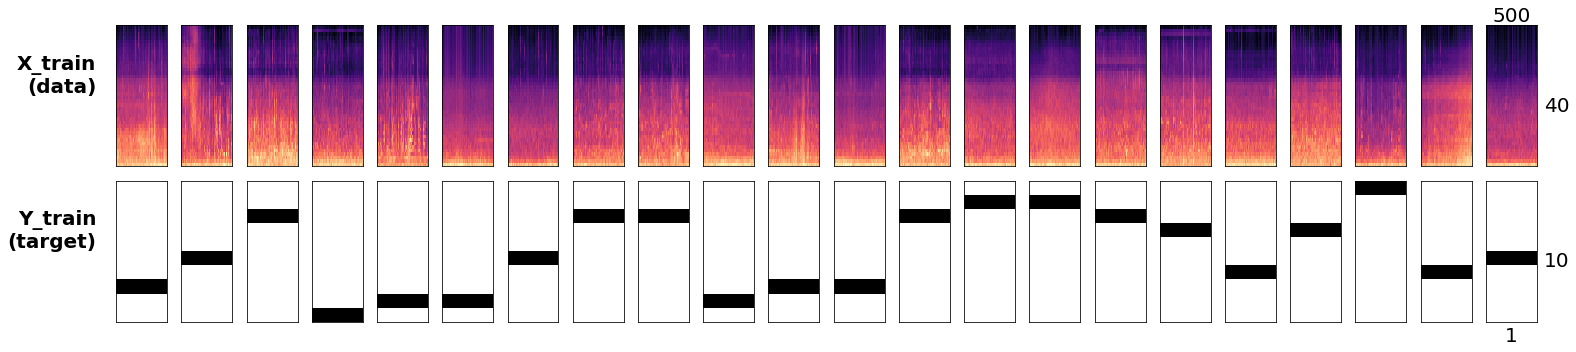

In [22]:
example_ids = numpy.random.choice(range(X_train.shape[0]), 22, replace=False)
fig, axes = plt.subplots(2, len(example_ids), figsize=(22, 5))
fig.subplots_adjust(top=1.0, bottom=0.0, right=1.0, hspace=0.00, wspace=0.00)
for i, id in enumerate(example_ids):
    current_x = X_train[id,:,:]
    current_y = Y_train[id,:]
        
    plt.sca(axes[0, i])
    dcase_util.containers.FeatureContainer(current_x).plot(plot=False)
    
    plt.sca(axes[1, i])
    dcase_util.containers.BinaryMatrix2DContainer(numpy.expand_dims(current_y,-1)).plot(plot=False)
    
axes[0, -1].yaxis.set_label_position("right")
axes[0, -1].xaxis.set_label_position("top")
axes[0, -1].set_ylabel('40', rotation=0, fontsize=20, labelpad=20)
axes[0, -1].set_xlabel('500',fontsize=20)

axes[1, -1].yaxis.set_label_position("right")
axes[1, -1].xaxis.set_label_position("bottom")
axes[1, -1].set_ylabel('10', rotation=0, fontsize=20, labelpad=20)
axes[1, -1].set_xlabel('1',fontsize=20)

axes[0, 0].set_ylabel('X_train\n(data)', rotation=0, fontsize=20, labelpad=20, fontweight='bold', ha='right')
axes[1, 0].yaxis.set_label_position("left")
axes[1, 0].set_ylabel('Y_train\n(target)', rotation=0, fontsize=20, labelpad=20, fontweight='bold', ha='right')    

plt.tight_layout()

# Neural network structure

Neural network consists of two CNN blocks, the pooling layer, and the output layer. 

Next, we create a neural network structure layer by layer.

In [23]:
feature_vector_length = mel_extractor.n_mels   # Number of mel bands

**Input** layer:

In [24]:
input_layer = Input(
    shape=(feature_vector_length, sequence_length), 
    name='Input'
)

**Reshaping** layer to add channel axis into input data:

In [25]:
x = Reshape(
    target_shape=(feature_vector_length, sequence_length, 1), 
    name='Input_Reshape'
)(input_layer)

In [26]:
print('Output shape','(sequence, frequency, time, channel):\n', x.shape)

Output shape (sequence, frequency, time, channel):
 (None, 40, 500, 1)


Two convolutional **layer groups** consisting of:

1) **Convolution** to capture context and extract high-level features: <br>*kernel 5x5 and filters 64*

In [27]:
x = Conv2D(
    filters=64, 
    kernel_size=(5, 5), 
    activation='linear', 
    padding='same', 
    data_format='channels_last',
    name='Conv1'
)(x)

2) **Batch normalization** to enable higher learning rates

In [28]:
x = BatchNormalization(
    axis=-1, 
    name='Conv1_BatchNorm'
)(x)

3) **Activation** (ReLu) to introduce non-linearity

In [29]:
x = Activation(
    activation='relu', name='Conv1_Activation'
)(x)

4) **Pooling** (2D) to extract dominant features

In [30]:
x = MaxPooling2D(
    pool_size=(2, 4), name='Conv1_Pooling'
)(x)

5) **Dropout** to avoid overfitting

In [31]:
x = Dropout(
    rate=0.2, name='Conv1_DropOut'
)(x)

In [32]:
print('Output shape of CNN layer group 1','(sequence, frequency, time, feature):\n', x.shape)

Output shape of CNN layer group 1 (sequence, frequency, time, feature):
 (None, 20, 125, 64)


Second convolutional layer group:

In [33]:
x = Conv2D(filters=64, kernel_size=(5, 5), activation='linear', padding='same', data_format='channels_last', name='Conv2')(x)
x = BatchNormalization(axis=-1, name='Conv2_BatchNorm')(x)
x = Activation(activation='relu', name='Conv2_Activation')(x)
x = MaxPooling2D(pool_size=(2, 2), name='Conv2_Pooling')(x)
x = Dropout(rate=0.2, name='Conv2_DropOut')(x)

In [34]:
print('Output shape of CNN layer group 2','(sequence, frequency, time, feature):\n', x.shape)

Output shape of CNN layer group 2 (sequence, frequency, time, feature):
 (None, 10, 62, 64)


**Global max pooling** is applied to the output of the last convolutional layer group to summarize output into a **single vector**:

In [35]:
x = GlobalMaxPooling2D(
    data_format='channels_last', 
    name='GlobalPooling'
)(x)

In [36]:
print('Output shape','(sequence, feature):\n', x.shape)

Output shape (sequence, feature):
 (None, 64)


**Output layer** as fully-connected layer with a softmax activation:

In [37]:
output_layer = Dense(
    units=len(db.scene_labels()), 
    activation='softmax', 
    name='Output'
)(x)

In [38]:
print('Output shape','(sequence, class):\n', output_layer.shape)

Output shape (sequence, class):
 (None, 10)


Create a model network:

In [39]:
model = Model(inputs=input_layer, outputs=output_layer)

In [40]:
dcase_util.tfkeras.model_summary_string(
    keras_model=model,
    mode='extended', 
    show_parameters=False, 
    display=True
) # alternative for print(model.summary()) to get html table

Layer name,Layer type,Output shape,Parameters
Input,InputLayer,"[(None, 40, 500)]",0
Input_Reshape,Reshape,"(None, 40, 500, 1)",0
Conv1,Conv2D,"(None, 40, 500, 64)",1664
Conv1_BatchNorm,BatchNorm,"(None, 40, 500, 64)",256
Conv1_Activation,Activation,"(None, 40, 500, 64)",0
Conv1_Pooling,MaxPooling2D,"(None, 20, 125, 64)",0
Conv1_DropOut,Dropout,"(None, 20, 125, 64)",0
Conv2,Conv2D,"(None, 20, 125, 64)",102464
Conv2_BatchNorm,BatchNorm,"(None, 20, 125, 64)",256
Conv2_Activation,Activation,"(None, 20, 125, 64)",0


# Training

Key parameters:

- **Loss** &ndash; function used to measure the difference between target and prediction <br> `categorical_crossentropy`
- **Metric** &ndash; evaluated for training and validation data during the learning process<br> `categorical_accuracy`
- **Optimizer** &ndash; function used to update the model to minimize the loss
- **Learning rate** &ndash; how much model parameters are updated at each step
- **Batch size** &ndash; how many learning examples are processed before updating model parameters
- **Epochs** &ndash; how many times all learning data is gone through during the training procedure

In [41]:
callback_list=[
    dcase_util.tfkeras.ProgressLoggerCallback(
        epochs=100, 
        metric='categorical_accuracy', 
        loss='categorical_crossentropy', 
        output_type='console', 
        show_timing=False,
    ),
    dcase_util.tfkeras.StasherCallback(
        epochs=100, 
        monitor='val_categorical_accuracy'
    )
]

Compile the model:

In [42]:
model.compile(
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
    optimizer=keras.optimizers.Adam(learning_rate=0.001, decay=0.001)
)

Start learning process:

In [43]:
# Track power consumption during the training
tracker = EmissionsTracker("Sound Classification Tutorial", output_dir=os.path.join('data', 'training_codecarbon'))
tracker.start()
# Track time
start_time = time.time()
# Start training process
history = model.fit(
    x=X_train, y=Y_train,
    validation_data=(X_validation, Y_validation),
    callbacks=callback_list,
    verbose=0,
    epochs=100,
    batch_size=16
)
# Stop tracking
stop_time = time.time()
tracker.stop()

  Training
            Loss                                Metric                             
            categorical_crossentropy            categorical_accuracy               
  Epoch     Train             Val               Train             Val              
  -------   ---------------   ---------------   ---------------   ---------------  
  1         1.5220            2.0769            0.4424            0.2540           
  2         1.3433            2.1087            0.5002            0.3013           
  3         1.2371            1.3679            0.5547            0.4582           
  4         1.1703            1.3396            0.5728            0.4799           
  5         1.1085            1.2572            0.5975            0.5257           
  6         1.0551            1.2067            0.6176            0.5402           
  7         1.0376            1.2114            0.6246            0.5327           
  8         0.9776            1.1798            0.6500           

  94        0.4812            1.1066            0.8469            0.5719           
  95        0.4877            1.0739            0.8449            0.5739           
  96        0.4835            1.0134            0.8459            0.6097           
  97        0.4866            1.0716            0.8406            0.5734           
  98        0.4801            0.9953            0.8462            0.6182           
  99        0.4842            1.0414            0.8384            0.5921           


Time used for training:

In [44]:
print('{time:.4} min'.format(time=(stop_time - start_time)/60))

9.04 min


Total energy consumed during training:

In [45]:
print('{value:0.3f} kWh'.format(value=tracker._total_energy.kWh))

0.029 kWh


## Best performing model

The best performing model was stored during the training process in `StasherCallback`:

In [47]:
for callback in callback_list:
    if isinstance(callback, dcase_util.tfkeras.StasherCallback):                
        model.set_weights(callback.get_best()['weights'])       # Fetch the best performing model        
        callback.show()                                         # Show information
        break

Save model and training history:

In [48]:
# Save model
model.save(model_filename)

# Save training history
dcase_util.files.Serializer().save_cpickle(
    filename=os.path.join(data_storage_path, 'model_asc_training_history.cpickle'), 
    data=history.history
)

## Training history

In [49]:
hist = dcase_util.files.Serializer().load_cpickle(
    filename=os.path.join(data_storage_path, 'model_asc_training_history.cpickle')
)

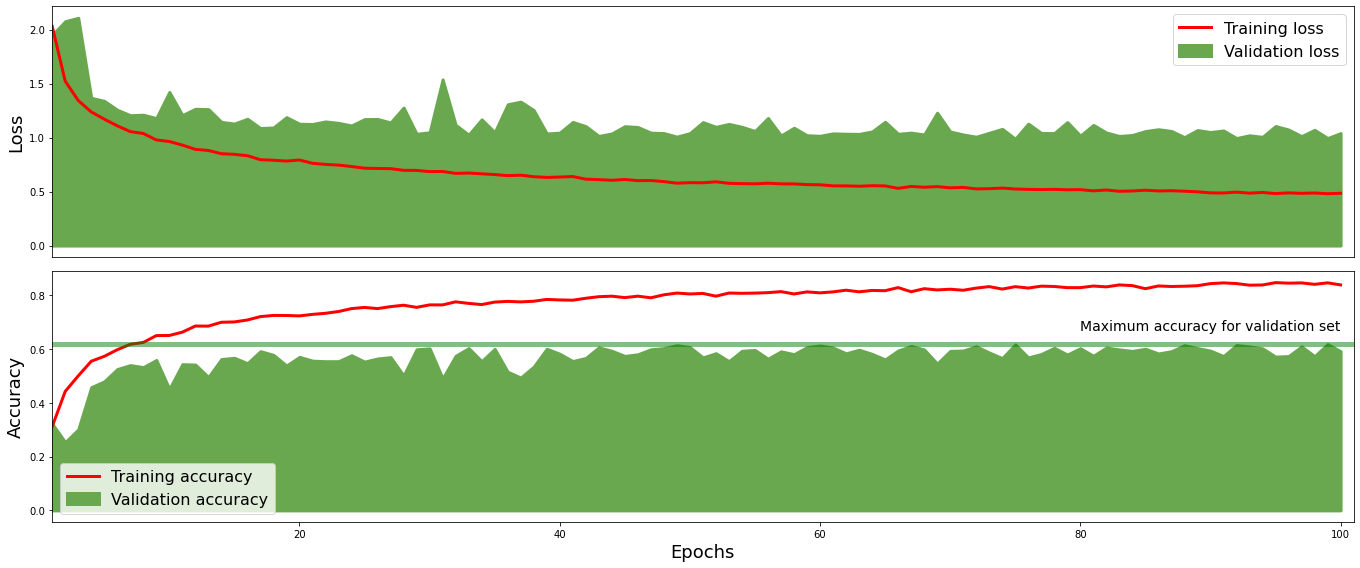

In [50]:
epochs = range(1, len(hist['loss']) + 1)
fig = plt.figure(figsize=(19,8))
plt.subplot(2,1,1)
plt.plot(epochs, hist['loss'], color='red', linewidth=3, label='Training loss')
#plt.plot(epochs, hist['val_loss'], color='green', linewidth=3, label='Validation loss')
plt.fill_between(epochs, numpy.squeeze(numpy.array(hist['val_loss'])), color='#6aa84f', linewidth=3, label='Validation loss')
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='best', fontsize=16)
panel = plt.gca()
panel.get_xaxis().set_visible(False)
panel.set_xlim([1,len(hist['loss']) + 1])

plt.subplot(2,1,2)
plt.plot(epochs, hist['categorical_accuracy'], color='red', linewidth=3, label='Training accuracy')
#plt.plot(epochs, hist['val_categorical_accuracy'], color='green', linewidth=3, label='Validation accuracy')
plt.fill_between(epochs, numpy.squeeze(numpy.array(hist['val_categorical_accuracy'])), color='#6aa84f', linewidth=3, label='Validation accuracy')

acc_min_index = numpy.argmax(hist['val_categorical_accuracy'])
plt.axhline(hist['val_categorical_accuracy'][acc_min_index], color='green', linestyle='-', linewidth=5, alpha=0.5)
plt.annotate('Maximum accuracy for validation set', xy=(len(hist['loss']),hist['val_categorical_accuracy'][acc_min_index]+0.05), fontsize=14, ha='right')
panel = plt.gca()
panel.set_xlim([1,len(hist['loss']) + 1])

plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.legend(loc='best', fontsize=16)
plt.tight_layout()
plt.show()

# Testing stage

In [51]:
model = keras.models.load_model(model_filename) # Load model

**Extract** features for test item:

In [52]:
# Get test item
item = db.test(fold=1)[0]

# Extract features
features = mel_extractor.extract(
    AudioContainer().load(filename=item.filename, mono=True)
)[:,:sequence_length]

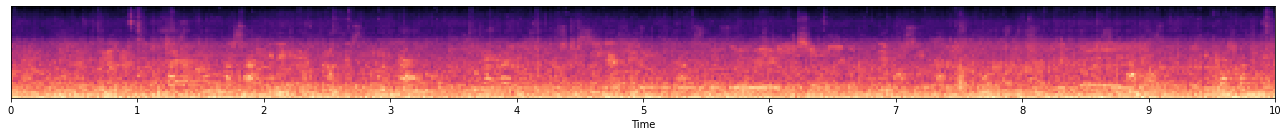

In [53]:
dcase_util.containers.FeatureContainer(features, time_resolution=0.02).plot(figsize=(18,2))

**Reshape** the matrix to match the model input:

In [54]:
input_data = numpy.expand_dims(features, 0)

In [55]:
print('input_data shape', '(sequence, frequency, time):\n', input_data.shape)

input_data shape (sequence, frequency, time):
 (1, 40, 500)


Feed input data into the model to get **probabilities for each scene class**:

In [56]:
probabilities = model.predict(x=input_data)

In [57]:
probabilities

array([[0.35295883, 0.00327344, 0.00225771, 0.09634162, 0.00080265,
        0.14913237, 0.24045765, 0.14413665, 0.00086025, 0.00977885]],
      dtype=float32)

**Classify** by selecting the class giving **maximum output**:

In [58]:
frame_decisions = dcase_util.data.ProbabilityEncoder().binarization(
    probabilities=probabilities.T,
    binarization_type='frame_max'
).T  

In [59]:
frame_decisions

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Scene label:

In [60]:
scene_labels[numpy.argmax(frame_decisions)]

'airport'

## Going through all test material

In [61]:
res = dcase_util.containers.MetaDataContainer(filename=os.path.join(data_storage_path, 'results_asc.csv'))

for item in db.test(fold=1):
    print('Test', db.absolute_to_relative_path(item.filename))
    # Load features
    features = get_feature_matrix(item.filename)[:,:sequence_length]
    #features = mel_extractor.extract(
    #    dcase_util.containers.AudioContainer().load(filename=item.filename, mono=True)
    #)[:,:sequence_length]
    input_data = numpy.expand_dims(features, 0)

    # Get network output
    probabilities = model.predict(x=input_data)

    # Binarization and getting estimated scene label
    frame_decisions = dcase_util.data.ProbabilityEncoder().binarization(
        probabilities=probabilities.T,
        binarization_type='frame_max'
    )   
    estimated_scene_label = scene_labels[numpy.argmax(frame_decisions)]
    
    # Store result into results container
    res.append(
        {
            'filename': db.absolute_to_relative_path(item.filename),
            'scene_label': estimated_scene_label
        }
    )
    
# Save results container
res.save().show(mode='print')

Test audio/airport-barcelona-203-6122-a.wav
Test audio/airport-barcelona-203-6123-a.wav
Test audio/airport-barcelona-203-6124-a.wav
Test audio/airport-barcelona-203-6125-a.wav
Test audio/airport-barcelona-203-6126-a.wav
Test audio/airport-barcelona-203-6127-a.wav
Test audio/airport-barcelona-203-6128-a.wav
Test audio/airport-barcelona-203-6129-a.wav
Test audio/airport-barcelona-203-6130-a.wav
Test audio/airport-barcelona-203-6131-a.wav
Test audio/airport-barcelona-203-6132-a.wav
Test audio/airport-barcelona-203-6133-a.wav
Test audio/airport-barcelona-203-6134-a.wav
Test audio/airport-barcelona-203-6135-a.wav
Test audio/airport-barcelona-203-6136-a.wav
Test audio/airport-barcelona-203-6137-a.wav
Test audio/airport-helsinki-204-6138-a.wav
Test audio/airport-helsinki-204-6139-a.wav
Test audio/airport-helsinki-204-6140-a.wav
Test audio/airport-helsinki-204-6141-a.wav
Test audio/airport-helsinki-204-6142-a.wav
Test audio/airport-helsinki-204-6143-a.wav
Test audio/airport-helsinki-204-6144-a

Test audio/airport-stockholm-208-6317-a.wav
Test audio/airport-stockholm-208-6318-a.wav
Test audio/airport-stockholm-208-6319-a.wav
Test audio/airport-stockholm-208-6320-a.wav
Test audio/airport-stockholm-208-6321-a.wav
Test audio/airport-stockholm-208-6322-a.wav
Test audio/airport-stockholm-208-6323-a.wav
Test audio/airport-stockholm-208-6324-a.wav
Test audio/airport-stockholm-208-6325-a.wav
Test audio/airport-stockholm-208-6326-a.wav
Test audio/airport-stockholm-208-6327-a.wav
Test audio/airport-stockholm-208-6328-a.wav
Test audio/airport-stockholm-208-6329-a.wav
Test audio/airport-stockholm-208-6330-a.wav
Test audio/airport-stockholm-208-6331-a.wav
Test audio/airport-stockholm-208-6332-a.wav
Test audio/airport-stockholm-208-6333-a.wav
Test audio/airport-stockholm-208-6334-a.wav
Test audio/airport-stockholm-208-6335-a.wav
Test audio/airport-stockholm-208-6336-a.wav
Test audio/airport-stockholm-208-6337-a.wav
Test audio/airport-stockholm-208-6338-a.wav
Test audio/airport-stockholm-208

Test audio/bus-paris-215-6523-a.wav
Test audio/bus-paris-215-6524-a.wav
Test audio/bus-paris-215-6525-a.wav
Test audio/bus-paris-215-6526-a.wav
Test audio/bus-paris-215-6527-a.wav
Test audio/bus-paris-215-6528-a.wav
Test audio/bus-paris-215-6529-a.wav
Test audio/bus-paris-215-6530-a.wav
Test audio/bus-paris-215-6531-a.wav
Test audio/bus-paris-215-6532-a.wav
Test audio/bus-paris-216-6533-a.wav
Test audio/bus-paris-216-6534-a.wav
Test audio/bus-paris-216-6535-a.wav
Test audio/bus-paris-216-6536-a.wav
Test audio/bus-paris-216-6537-a.wav
Test audio/bus-paris-216-6538-a.wav
Test audio/bus-paris-216-6539-a.wav
Test audio/bus-paris-216-6540-a.wav
Test audio/bus-paris-216-6541-a.wav
Test audio/bus-paris-216-6542-a.wav
Test audio/bus-paris-216-6543-a.wav
Test audio/bus-paris-216-6544-a.wav
Test audio/bus-stockholm-217-6545-a.wav
Test audio/bus-stockholm-217-6546-a.wav
Test audio/bus-stockholm-217-6547-a.wav
Test audio/bus-stockholm-217-6548-a.wav
Test audio/bus-stockholm-217-6549-a.wav
Test aud

Test audio/metro-helsinki-222-6728-a.wav
Test audio/metro-helsinki-222-6729-a.wav
Test audio/metro-helsinki-222-6730-a.wav
Test audio/metro-helsinki-222-6731-a.wav
Test audio/metro-helsinki-222-6732-a.wav
Test audio/metro-helsinki-222-6733-a.wav
Test audio/metro-helsinki-222-6734-a.wav
Test audio/metro-helsinki-222-6735-a.wav
Test audio/metro-helsinki-222-6736-a.wav
Test audio/metro-helsinki-222-6737-a.wav
Test audio/metro-helsinki-222-6738-a.wav
Test audio/metro-helsinki-222-6739-a.wav
Test audio/metro-helsinki-222-6740-a.wav
Test audio/metro-helsinki-222-6741-a.wav
Test audio/metro-helsinki-222-6742-a.wav
Test audio/metro-helsinki-222-6743-a.wav
Test audio/metro-helsinki-222-6744-a.wav
Test audio/metro-helsinki-222-6745-a.wav
Test audio/metro-helsinki-222-6746-a.wav
Test audio/metro-helsinki-222-6747-a.wav
Test audio/metro-helsinki-222-6748-a.wav
Test audio/metro-helsinki-222-6749-a.wav
Test audio/metro-helsinki-222-6750-a.wav
Test audio/metro-helsinki-222-6751-a.wav
Test audio/metro

Test audio/metro_station-barcelona-230-6924-a.wav
Test audio/metro_station-barcelona-230-6925-a.wav
Test audio/metro_station-barcelona-230-6926-a.wav
Test audio/metro_station-barcelona-230-6927-a.wav
Test audio/metro_station-barcelona-230-6928-a.wav
Test audio/metro_station-barcelona-230-6929-a.wav
Test audio/metro_station-barcelona-230-6930-a.wav
Test audio/metro_station-barcelona-230-6931-a.wav
Test audio/metro_station-barcelona-230-6932-a.wav
Test audio/metro_station-barcelona-230-6933-a.wav
Test audio/metro_station-barcelona-230-6934-a.wav
Test audio/metro_station-barcelona-230-6935-a.wav
Test audio/metro_station-barcelona-230-6936-a.wav
Test audio/metro_station-barcelona-230-6937-a.wav
Test audio/metro_station-barcelona-230-6938-a.wav
Test audio/metro_station-barcelona-230-6939-a.wav
Test audio/metro_station-barcelona-230-6940-a.wav
Test audio/metro_station-barcelona-230-6941-a.wav
Test audio/metro_station-barcelona-230-6942-a.wav
Test audio/metro_station-barcelona-230-6943-a.wav


Test audio/metro_station-stockholm-239-7094-a.wav
Test audio/metro_station-stockholm-239-7095-a.wav
Test audio/metro_station-stockholm-239-7096-a.wav
Test audio/metro_station-stockholm-239-7097-a.wav
Test audio/metro_station-stockholm-239-7098-a.wav
Test audio/metro_station-stockholm-239-7099-a.wav
Test audio/metro_station-stockholm-239-7100-a.wav
Test audio/metro_station-stockholm-239-7101-a.wav
Test audio/metro_station-stockholm-239-7102-a.wav
Test audio/metro_station-stockholm-239-7103-a.wav
Test audio/metro_station-stockholm-239-7104-a.wav
Test audio/metro_station-stockholm-239-7105-a.wav
Test audio/metro_station-stockholm-239-7106-a.wav
Test audio/metro_station-stockholm-239-7107-a.wav
Test audio/metro_station-stockholm-239-7108-a.wav
Test audio/metro_station-stockholm-239-7109-a.wav
Test audio/metro_station-stockholm-239-7110-a.wav
Test audio/metro_station-stockholm-239-7111-a.wav
Test audio/metro_station-stockholm-239-7112-a.wav
Test audio/metro_station-vienna-240-7113-a.wav
Tes

Test audio/park-paris-244-7290-a.wav
Test audio/park-paris-244-7291-a.wav
Test audio/park-paris-244-7292-a.wav
Test audio/park-paris-244-7293-a.wav
Test audio/park-paris-244-7294-a.wav
Test audio/park-paris-244-7295-a.wav
Test audio/park-paris-244-7296-a.wav
Test audio/park-paris-244-7297-a.wav
Test audio/park-stockholm-245-7298-a.wav
Test audio/park-stockholm-245-7299-a.wav
Test audio/park-stockholm-245-7300-a.wav
Test audio/park-stockholm-245-7301-a.wav
Test audio/park-stockholm-245-7302-a.wav
Test audio/park-stockholm-245-7303-a.wav
Test audio/park-stockholm-245-7304-a.wav
Test audio/park-stockholm-245-7305-a.wav
Test audio/park-stockholm-245-7306-a.wav
Test audio/park-stockholm-245-7307-a.wav
Test audio/park-stockholm-245-7308-a.wav
Test audio/park-stockholm-245-7309-a.wav
Test audio/park-stockholm-245-7310-a.wav
Test audio/park-stockholm-245-7311-a.wav
Test audio/park-stockholm-245-7312-a.wav
Test audio/park-stockholm-245-7313-a.wav
Test audio/park-stockholm-245-7314-a.wav
Test au

Test audio/public_square-london-250-7476-a.wav
Test audio/public_square-london-250-7477-a.wav
Test audio/public_square-london-250-7478-a.wav
Test audio/public_square-london-250-7479-a.wav
Test audio/public_square-london-250-7480-a.wav
Test audio/public_square-london-250-7481-a.wav
Test audio/public_square-london-250-7482-a.wav
Test audio/public_square-london-250-7483-a.wav
Test audio/public_square-london-250-7484-a.wav
Test audio/public_square-london-250-7485-a.wav
Test audio/public_square-london-250-7486-a.wav
Test audio/public_square-london-250-7487-a.wav
Test audio/public_square-london-250-7488-a.wav
Test audio/public_square-london-250-7489-a.wav
Test audio/public_square-london-250-7490-a.wav
Test audio/public_square-london-250-7491-a.wav
Test audio/public_square-london-250-7492-a.wav
Test audio/public_square-london-250-7493-a.wav
Test audio/public_square-london-250-7494-a.wav
Test audio/public_square-london-250-7495-a.wav
Test audio/public_square-london-250-7496-a.wav
Test audio/pu

Test audio/shopping_mall-helsinki-255-7646-a.wav
Test audio/shopping_mall-helsinki-255-7647-a.wav
Test audio/shopping_mall-helsinki-255-7648-a.wav
Test audio/shopping_mall-helsinki-255-7649-a.wav
Test audio/shopping_mall-helsinki-255-7650-a.wav
Test audio/shopping_mall-helsinki-255-7651-a.wav
Test audio/shopping_mall-helsinki-255-7652-a.wav
Test audio/shopping_mall-helsinki-255-7653-a.wav
Test audio/shopping_mall-helsinki-255-7654-a.wav
Test audio/shopping_mall-helsinki-255-7655-a.wav
Test audio/shopping_mall-helsinki-255-7656-a.wav
Test audio/shopping_mall-helsinki-255-7657-a.wav
Test audio/shopping_mall-helsinki-255-7658-a.wav
Test audio/shopping_mall-helsinki-255-7659-a.wav
Test audio/shopping_mall-helsinki-255-7660-a.wav
Test audio/shopping_mall-helsinki-255-7661-a.wav
Test audio/shopping_mall-helsinki-255-7662-a.wav
Test audio/shopping_mall-helsinki-255-7663-a.wav
Test audio/shopping_mall-helsinki-255-7664-a.wav
Test audio/shopping_mall-helsinki-255-7665-a.wav
Test audio/shopping_

Test audio/shopping_mall-stockholm-258-7819-a.wav
Test audio/shopping_mall-stockholm-258-7820-a.wav
Test audio/shopping_mall-stockholm-258-7821-a.wav
Test audio/shopping_mall-stockholm-258-7822-a.wav
Test audio/shopping_mall-stockholm-258-7823-a.wav
Test audio/shopping_mall-stockholm-258-7824-a.wav
Test audio/shopping_mall-stockholm-258-7825-a.wav
Test audio/shopping_mall-stockholm-258-7826-a.wav
Test audio/shopping_mall-stockholm-258-7827-a.wav
Test audio/shopping_mall-stockholm-258-7828-a.wav
Test audio/shopping_mall-stockholm-258-7829-a.wav
Test audio/shopping_mall-stockholm-258-7830-a.wav
Test audio/shopping_mall-stockholm-258-7831-a.wav
Test audio/shopping_mall-stockholm-258-7832-a.wav
Test audio/shopping_mall-stockholm-258-7833-a.wav
Test audio/shopping_mall-stockholm-258-7834-a.wav
Test audio/shopping_mall-stockholm-258-7835-a.wav
Test audio/shopping_mall-stockholm-258-7836-a.wav
Test audio/shopping_mall-stockholm-258-7837-a.wav
Test audio/shopping_mall-stockholm-258-7838-a.wav


Test audio/street_pedestrian-london-263-7979-a.wav
Test audio/street_pedestrian-london-263-7980-a.wav
Test audio/street_pedestrian-london-263-7981-a.wav
Test audio/street_pedestrian-london-263-7982-a.wav
Test audio/street_pedestrian-london-263-7983-a.wav
Test audio/street_pedestrian-london-263-7984-a.wav
Test audio/street_pedestrian-london-263-7985-a.wav
Test audio/street_pedestrian-london-263-7986-a.wav
Test audio/street_pedestrian-london-263-7987-a.wav
Test audio/street_pedestrian-london-263-7988-a.wav
Test audio/street_pedestrian-london-263-7989-a.wav
Test audio/street_pedestrian-london-263-7990-a.wav
Test audio/street_pedestrian-london-263-7991-a.wav
Test audio/street_pedestrian-london-263-7992-a.wav
Test audio/street_pedestrian-london-263-7993-a.wav
Test audio/street_pedestrian-london-263-7994-a.wav
Test audio/street_pedestrian-london-263-7995-a.wav
Test audio/street_pedestrian-london-263-7996-a.wav
Test audio/street_pedestrian-london-263-7997-a.wav
Test audio/street_pedestrian-lo

Test audio/street_traffic-barcelona-268-8138-a.wav
Test audio/street_traffic-barcelona-268-8139-a.wav
Test audio/street_traffic-barcelona-268-8140-a.wav
Test audio/street_traffic-barcelona-268-8141-a.wav
Test audio/street_traffic-barcelona-268-8142-a.wav
Test audio/street_traffic-barcelona-268-8143-a.wav
Test audio/street_traffic-barcelona-268-8144-a.wav
Test audio/street_traffic-barcelona-268-8145-a.wav
Test audio/street_traffic-barcelona-268-8146-a.wav
Test audio/street_traffic-barcelona-268-8147-a.wav
Test audio/street_traffic-barcelona-268-8148-a.wav
Test audio/street_traffic-barcelona-268-8149-a.wav
Test audio/street_traffic-barcelona-268-8150-a.wav
Test audio/street_traffic-barcelona-268-8151-a.wav
Test audio/street_traffic-barcelona-268-8152-a.wav
Test audio/street_traffic-barcelona-268-8153-a.wav
Test audio/street_traffic-barcelona-268-8154-a.wav
Test audio/street_traffic-barcelona-268-8155-a.wav
Test audio/street_traffic-barcelona-268-8156-a.wav
Test audio/street_traffic-barce

Test audio/street_traffic-paris-272-8305-a.wav
Test audio/street_traffic-paris-272-8306-a.wav
Test audio/street_traffic-stockholm-273-8307-a.wav
Test audio/street_traffic-stockholm-273-8308-a.wav
Test audio/street_traffic-stockholm-273-8309-a.wav
Test audio/street_traffic-stockholm-273-8310-a.wav
Test audio/street_traffic-stockholm-273-8311-a.wav
Test audio/street_traffic-stockholm-273-8312-a.wav
Test audio/street_traffic-stockholm-273-8313-a.wav
Test audio/street_traffic-stockholm-273-8314-a.wav
Test audio/street_traffic-stockholm-273-8315-a.wav
Test audio/street_traffic-stockholm-273-8316-a.wav
Test audio/street_traffic-stockholm-273-8317-a.wav
Test audio/street_traffic-stockholm-273-8318-a.wav
Test audio/street_traffic-stockholm-273-8319-a.wav
Test audio/street_traffic-stockholm-273-8320-a.wav
Test audio/street_traffic-stockholm-273-8321-a.wav
Test audio/street_traffic-stockholm-273-8322-a.wav
Test audio/street_traffic-stockholm-273-8323-a.wav
Test audio/street_traffic-stockholm-273

Test audio/tram-paris-280-8494-a.wav
Test audio/tram-paris-280-8495-a.wav
Test audio/tram-paris-280-8496-a.wav
Test audio/tram-paris-280-8497-a.wav
Test audio/tram-paris-280-8498-a.wav
Test audio/tram-paris-280-8499-a.wav
Test audio/tram-paris-280-8500-a.wav
Test audio/tram-paris-280-8501-a.wav
Test audio/tram-paris-280-8502-a.wav
Test audio/tram-paris-280-8503-a.wav
Test audio/tram-paris-280-8504-a.wav
Test audio/tram-paris-280-8505-a.wav
Test audio/tram-paris-280-8506-a.wav
Test audio/tram-paris-280-8507-a.wav
Test audio/tram-paris-280-8508-a.wav
Test audio/tram-paris-280-8509-a.wav
Test audio/tram-paris-280-8510-a.wav
Test audio/tram-paris-281-8511-a.wav
Test audio/tram-paris-281-8512-a.wav
Test audio/tram-paris-281-8513-a.wav
Test audio/tram-paris-281-8514-a.wav
Test audio/tram-paris-281-8515-a.wav
Test audio/tram-paris-281-8516-a.wav
Test audio/tram-paris-281-8517-a.wav
Test audio/tram-paris-281-8518-a.wav
Test audio/tram-paris-281-8519-a.wav
Test audio/tram-paris-281-8520-a.wav
T

# Evaluation

## Preparing data for evaluation

In [63]:
# Load reference and system output
reference_scene_list = db.eval(fold=1)
estimated_scene_list = dcase_util.containers.MetaDataContainer(
    filename=os.path.join(data_storage_path, 'results_asc.csv')
).load()
# Collect test items into lists in same order
y_true = []
y_pred = []
for item_id, item in enumerate(reference_scene_list):
    y_true.append(item.scene_label)
    for item_estimated in estimated_scene_list:
        if os.path.split(item_estimated.filename)[-1] == os.path.split(item.filename)[-1]:
            y_pred.append(item_estimated.scene_label)
            break

## Calculating metric

In [64]:
import sklearn

# Get confusion matrix with counts
confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

# Transform matrix into percentages, normalize row-wise
conf = confusion_matrix * 100.0 / confusion_matrix.sum(axis=1)[:, numpy.newaxis]  

# Fetch class-wise accuracies from diagonal
class_wise_accuracies = numpy.diag(conf)                

# Calculate overall accuracy
macro_averaged_accuracy = numpy.mean(class_wise_accuracies)

In [65]:
print('Macro-averaged accuracy: {value:.1f} %'.format(value=macro_averaged_accuracy))

Macro-averaged accuracy: 62.5 %


## Class-wise accuracies

In [66]:
labels = db.scene_labels()
labels.append('Average')
values = class_wise_accuracies
values = numpy.append(values, numpy.mean(class_wise_accuracies))
log.table(
    cell_data=[
        labels,values
    ],
    column_headers=['Scene label', 'Accuracy'],
    column_types=['str30', 'float1'],
    row_separators=[10],
    scaling=120,
)

Scene label,Accuracy
airport,42.3
bus,66.5
metro,47.9
metro_station,53.3
park,83.1
public_square,44.0
shopping_mall,84.6
street_pedestrian,59.5
street_traffic,84.6
tram,59.0


## Confusion matrix

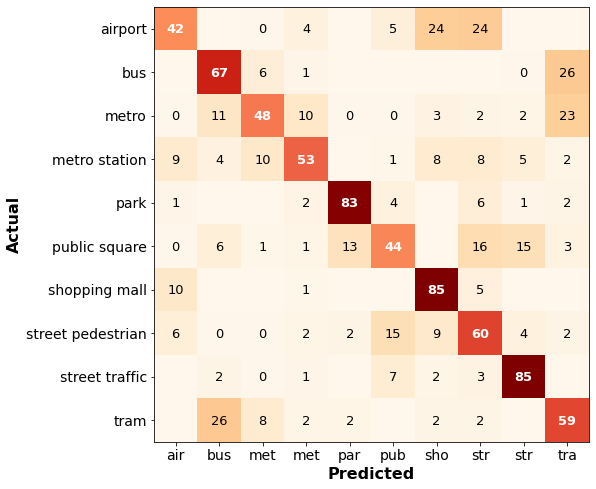

In [67]:
fig = plt.figure(figsize=(8,8))    
plt.imshow(conf, cmap=plt.cm.OrRd)
labels = []
labels_short = []
for label in db.scene_labels():
    labels.append(str(label.replace('_', ' ')))
    labels_short.append(label[0:3])    
plt.yticks(range(len(scene_labels)), labels, fontsize=14)
plt.xticks(range(len(scene_labels)), labels_short, fontsize=14)
plt.ylabel('Actual', fontsize=16, fontweight="bold")
plt.xlabel('Predicted', fontsize=16, fontweight="bold")
for x in range(len(scene_labels)):
    for y in range(len(scene_labels)):
        if conf[y, x] > 0:
            plt.text(x, y + 0.1, "{:.0f}".format(conf[y, x]), 
                     fontsize=13, ha='center', 
                     color= 'white' if (x==y) else 'black', 
                     weight= 'bold' if (x==y) else 'normal')  

## Confidence interval for the accuracy

In [68]:
from statsmodels.stats import proportion
Nref = len(y_true)
Ncorr = numpy.sum(numpy.diag(confusion_matrix))
ci95 = proportion.proportion_confint(
    count=Ncorr,
    nobs=Nref,
    alpha=0.05,
    method='normal'
)
print('95% confidence interval:', '{0:2.2f} - {1:2.2f}'.format(ci95[0]*100, ci95[1]*100))

95% confidence interval: 60.74 - 64.52


# How to improve:

- Collect **more material**
- Use **data augmentation** to generate more variability in learning examples
- Use **transfer learning** techniques to distill knowledge from other tasks
- Use different **network architectures**